In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import numpy as np

import time
from datetime import timedelta

In [14]:
class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.as_tensor(self.relative_importance, device=losses.device).clone().detach()        
        weighted_losses = rel_importance * losses
        return weighted_losses.mean()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=100, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, **kwargs)
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        return nesting_logits

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [16]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = {n: 0 for n in nesting_list}
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        for i, n in enumerate(nesting_list):
            _, predicted = outputs[i].max(1)
            correct[n] += predicted.eq(targets).sum().item()
        total += targets.size(0)

    avg_acc = 100. * sum(correct.values()) / (total * len(nesting_list))
    print(f"| {'Train':^6} {epoch:^3} | Loss: {train_loss/(batch_idx+1):^7.3f} | Acc: {avg_acc:^6.3f}% |")

In [18]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct_top1 = {n: 0 for n in nesting_list}
    correct_top5 = {n: 0 for n in nesting_list}
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            for i, n in enumerate(nesting_list):
                _, predicted = outputs[i].max(1)
                correct_top1[n] += predicted.eq(targets).sum().item()
                
                _, top5_pred = outputs[i].topk(5, 1, True, True)
                correct_top5[n] += top5_pred.eq(targets.view(-1, 1)).sum().item()
            
            total += targets.size(0)

    avg_top1 = sum(100. * correct_top1[n] / total for n in nesting_list) / len(nesting_list)
    avg_top5 = sum(100. * correct_top5[n] / total for n in nesting_list) / len(nesting_list)
    
    print("\n┌──────────┬────────────┬────────────┐")
    print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │ {'Top-5 Acc':^10} │")
    print("├──────────┼────────────┼────────────┤")
    
    for n in nesting_list:
        top1 = 100. * correct_top1[n] / total
        top5 = 100. * correct_top5[n] / total
        print(f"│ {n:^8} │ {top1:>9.2f}% │ {top5:>9.2f}% │")
    
    print("├──────────┼────────────┼────────────┤")
    print(f"│ {'Average':^8} │ {avg_top1:>9.2f}% │ {avg_top5:>9.2f}% │")
    print("└──────────┴────────────┴────────────┘")
    
    return avg_top1 

In [7]:
nesting_list = [8, 16, 32, 64, 128, 256, 512]
relative_importance = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=10, efficient=False)
model = model.to(device)

In [8]:
criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

| Train   0  | Loss:  1.474  | Acc: 46.219% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     55.44% │     94.33% │
│    16    │     55.62% │     94.32% │
│    32    │     55.96% │     94.38% │
│    64    │     56.21% │     94.42% │
│   128    │     56.40% │     94.43% │
│   256    │     55.85% │     94.33% │
│   512    │     55.40% │     94.36% │
├──────────┼────────────┼────────────┤
│ Average  │     55.84% │     94.37% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train   1  | Loss:  1.066  | Acc: 62.395% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     61.03% │     94.44% │
│    16    │     61.06% │     94.53% │
│    32    │     61.30% │     95.06% │
│    64    │     61.72% │     95.46% │
│   128    │     61.71% │

| Train  13  | Loss:  0.509  | Acc: 82.858% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     78.56% │     98.47% │
│    16    │     79.08% │     98.99% │
│    32    │     79.23% │     99.04% │
│    64    │     79.14% │     99.02% │
│   128    │     79.09% │     99.02% │
│   256    │     79.07% │     99.03% │
│   512    │     79.06% │     99.02% │
├──────────┼────────────┼────────────┤
│ Average  │     79.03% │     98.94% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  14  | Loss:  0.499  | Acc: 83.147% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     76.76% │     98.03% │
│    16    │     78.00% │     98.57% │
│    32    │     77.77% │     98.62% │
│    64    │     77.76% │     98.61% │
│   128    │     77.89% │

| Train  26  | Loss:  0.352  | Acc: 88.075% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     86.33% │     99.37% │
│    16    │     86.67% │     99.50% │
│    32    │     86.57% │     99.50% │
│    64    │     86.53% │     99.50% │
│   128    │     86.56% │     99.51% │
│   256    │     86.56% │     99.50% │
│   512    │     86.56% │     99.52% │
├──────────┼────────────┼────────────┤
│ Average  │     86.54% │     99.49% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  27  | Loss:  0.330  | Acc: 88.698% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     85.38% │     99.19% │
│    16    │     85.58% │     99.41% │
│    32    │     85.52% │     99.40% │
│    64    │     85.49% │     99.39% │
│   128    │     85.52% │

| Train  39  | Loss:  0.131  | Acc: 95.587% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     89.86% │     99.39% │
│    16    │     89.82% │     99.53% │
│    32    │     89.84% │     99.55% │
│    64    │     89.78% │     99.55% │
│   128    │     89.78% │     99.57% │
│   256    │     89.79% │     99.57% │
│   512    │     89.80% │     99.57% │
├──────────┼────────────┼────────────┤
│ Average  │     89.81% │     99.53% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  40  | Loss:  0.113  | Acc: 96.239% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     90.70% │     99.50% │
│    16    │     90.80% │     99.55% │
│    32    │     90.83% │     99.55% │
│    64    │     90.85% │     99.56% │
│   128    │     90.87% │

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


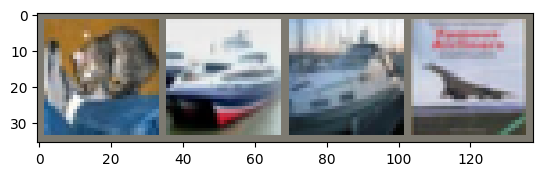

GroundTruth:	 3	8	8	0
Size		Image 1	Image 2	Image 3	Image 4
8		3	8	8	0
16		3	8	8	0
32		3	8	8	0
64		3	8	8	0
128		3	8	8	0
256		3	8	8	0
512		3	8	8	0


In [9]:
import time
from datetime import timedelta

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(50):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrlMEAN.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))

| Train   0  | Loss:  1.791  | Acc: 36.286% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   512    │     48.99% │     93.60% │
├──────────┼────────────┼────────────┤
│ Average  │     48.99% │     93.60% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   1  | Loss:  1.220  | Acc: 56.470% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   512    │     59.10% │     95.92% │
├──────────┼────────────┼────────────┤
│ Average  │     59.10% │     95.92% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   2  | Loss:  1.007  | Acc: 64.568% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  20  | Loss:  0.428  | Acc: 85.316% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   512    │     82.80% │     99.28% │
├──────────┼────────────┼────────────┤
│ Average  │     82.80% │     99.28% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  21  | Loss:  0.411  | Acc: 85.934% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   512    │     79.79% │     98.96% │
├──────────┼────────────┼────────────┤
│ Average  │     79.79% │     98.96% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  22  | Loss:  0.402  | Acc: 86.176% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  40  | Loss:  0.114  | Acc: 96.076% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   512    │     90.49% │     99.68% │
├──────────┼────────────┼────────────┤
│ Average  │     90.49% │     99.68% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  41  | Loss:  0.098  | Acc: 96.638% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   512    │     90.77% │     99.73% │
├──────────┼────────────┼────────────┤
│ Average  │     90.77% │     99.73% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  42  | Loss:  0.082  | Acc: 97.252% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


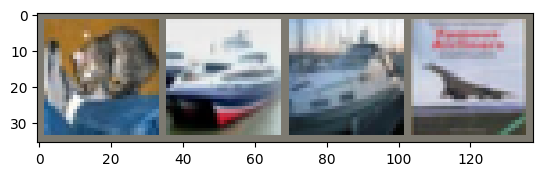

GroundTruth:	 3	8	8	0
Size		Image 1	Image 2	Image 3	Image 4
512		3	8	8	0


In [10]:
nesting_list = [512]
relative_importance = [1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=10, efficient=False)
model = model.to(device)

criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(50):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrlMEAN.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))

| Train   0  | Loss:  1.544  | Acc: 43.914% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   256    │     53.46% │     94.72% │
├──────────┼────────────┼────────────┤
│ Average  │     53.46% │     94.72% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   1  | Loss:  1.117  | Acc: 60.170% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   256    │     55.93% │     93.66% │
├──────────┼────────────┼────────────┤
│ Average  │     55.93% │     93.66% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   2  | Loss:  0.931  | Acc: 67.300% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  20  | Loss:  0.414  | Acc: 85.846% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   256    │     81.11% │     98.73% │
├──────────┼────────────┼────────────┤
│ Average  │     81.11% │     98.73% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  21  | Loss:  0.403  | Acc: 86.420% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   256    │     79.34% │     98.86% │
├──────────┼────────────┼────────────┤
│ Average  │     79.34% │     98.86% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  22  | Loss:  0.389  | Acc: 86.750% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  40  | Loss:  0.105  | Acc: 96.284% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   256    │     90.46% │     99.67% │
├──────────┼────────────┼────────────┤
│ Average  │     90.46% │     99.67% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  41  | Loss:  0.087  | Acc: 97.016% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   256    │     90.53% │     99.61% │
├──────────┼────────────┼────────────┤
│ Average  │     90.53% │     99.61% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  42  | Loss:  0.076  | Acc: 97.378% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


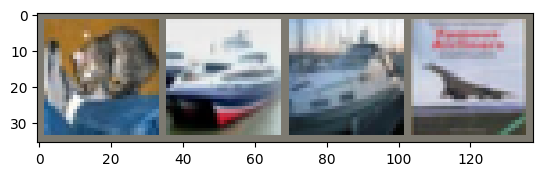

GroundTruth:	 3	8	8	0
Size		Image 1	Image 2	Image 3	Image 4
256		3	8	8	0


In [11]:
nesting_list = [256]
relative_importance = [1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=10, efficient=False)
model = model.to(device)

criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(50):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrlMEAN.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))

| Train   0  | Loss:  1.512  | Acc: 44.788% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     56.41% │     94.92% │
├──────────┼────────────┼────────────┤
│ Average  │     56.41% │     94.92% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   1  | Loss:  1.101  | Acc: 60.976% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     62.08% │     95.72% │
├──────────┼────────────┼────────────┤
│ Average  │     62.08% │     95.72% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train   2  | Loss:  0.941  | Acc: 66.820% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  20  | Loss:  0.422  | Acc: 85.536% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     83.91% │     99.34% │
├──────────┼────────────┼────────────┤
│ Average  │     83.91% │     99.34% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  21  | Loss:  0.409  | Acc: 86.054% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     84.79% │     99.27% │
├──────────┼────────────┼────────────┤
│ Average  │     84.79% │     99.27% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  22  | Loss:  0.394  | Acc: 86.500% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  40  | Loss:  0.107  | Acc: 96.310% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     91.10% │     99.71% │
├──────────┼────────────┼────────────┤
│ Average  │     91.10% │     99.71% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  41  | Loss:  0.090  | Acc: 96.974% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     90.98% │     99.70% │
├──────────┼────────────┼────────────┤
│ Average  │     90.98% │     99.70% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  42  | Loss:  0.076  | Acc: 97.384% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


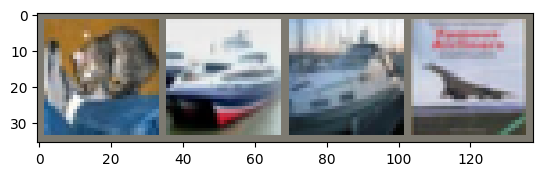

GroundTruth:	 3	8	8	0
Size		Image 1	Image 2	Image 3	Image 4
128		3	8	8	0


In [19]:
nesting_list = [128]
relative_importance = [1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=10, efficient=False)
model = model.to(device)

criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(50):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrlMEAN.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))

| Train   0  | Loss:  1.489  | Acc: 45.226% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    64    │     54.72% │     93.88% │
├──────────┼────────────┼────────────┤
│ Average  │     54.72% │     93.88% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train   1  | Loss:  1.078  | Acc: 61.804% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    64    │     63.41% │     96.05% │
├──────────┼────────────┼────────────┤
│ Average  │     63.41% │     96.05% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   2  | Loss:  0.893  | Acc: 68.872% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  20  | Loss:  0.421  | Acc: 85.554% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    64    │     79.83% │     99.08% │
├──────────┼────────────┼────────────┤
│ Average  │     79.83% │     99.08% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  21  | Loss:  0.403  | Acc: 86.318% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    64    │     84.24% │     99.16% │
├──────────┼────────────┼────────────┤
│ Average  │     84.24% │     99.16% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  22  | Loss:  0.398  | Acc: 86.510% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  40  | Loss:  0.107  | Acc: 96.250% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    64    │     90.09% │     99.67% │
├──────────┼────────────┼────────────┤
│ Average  │     90.09% │     99.67% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  41  | Loss:  0.094  | Acc: 96.790% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    64    │     91.02% │     99.65% │
├──────────┼────────────┼────────────┤
│ Average  │     91.02% │     99.65% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  42  | Loss:  0.077  | Acc: 97.392% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


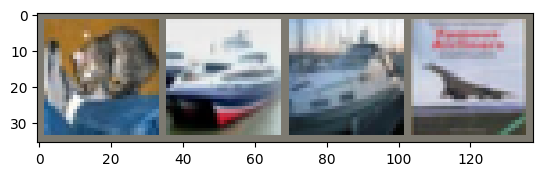

GroundTruth:	 3	8	8	0
Size		Image 1	Image 2	Image 3	Image 4
64		3	8	8	0


In [20]:
nesting_list = [64]
relative_importance = [1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=10, efficient=False)
model = model.to(device)

criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(50):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrlMEAN.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))

| Train   0  | Loss:  1.477  | Acc: 45.900% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    32    │     57.31% │     95.42% │
├──────────┼────────────┼────────────┤
│ Average  │     57.31% │     95.42% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   1  | Loss:  1.089  | Acc: 61.546% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    32    │     62.61% │     95.65% │
├──────────┼────────────┼────────────┤
│ Average  │     62.61% │     95.65% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   2  | Loss:  0.901  | Acc: 68.892% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  20  | Loss:  0.419  | Acc: 85.782% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    32    │     81.09% │     98.76% │
├──────────┼────────────┼────────────┤
│ Average  │     81.09% │     98.76% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  21  | Loss:  0.413  | Acc: 86.056% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    32    │     82.60% │     99.07% │
├──────────┼────────────┼────────────┤
│ Average  │     82.60% │     99.07% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  22  | Loss:  0.393  | Acc: 86.586% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  40  | Loss:  0.109  | Acc: 96.284% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    32    │     91.05% │     99.65% │
├──────────┼────────────┼────────────┤
│ Average  │     91.05% │     99.65% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  41  | Loss:  0.092  | Acc: 96.802% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    32    │     91.05% │     99.70% │
├──────────┼────────────┼────────────┤
│ Average  │     91.05% │     99.70% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  42  | Loss:  0.075  | Acc: 97.488% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


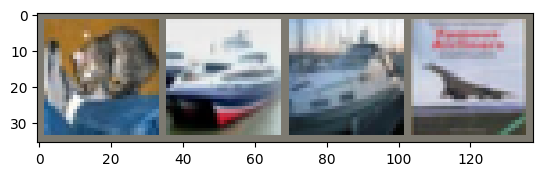

GroundTruth:	 3	8	8	0
Size		Image 1	Image 2	Image 3	Image 4
32		3	8	8	0


In [21]:
nesting_list = [32]
relative_importance = [1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=10, efficient=False)
model = model.to(device)

criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(50):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrlMEAN.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))

| Train   0  | Loss:  1.463  | Acc: 46.452% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    16    │     57.51% │     95.19% │
├──────────┼────────────┼────────────┤
│ Average  │     57.51% │     95.19% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   1  | Loss:  1.074  | Acc: 62.074% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    16    │     59.14% │     95.09% │
├──────────┼────────────┼────────────┤
│ Average  │     59.14% │     95.09% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   2  | Loss:  0.898  | Acc: 68.710% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  20  | Loss:  0.425  | Acc: 85.510% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    16    │     78.69% │     98.81% │
├──────────┼────────────┼────────────┤
│ Average  │     78.69% │     98.81% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  21  | Loss:  0.415  | Acc: 85.744% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    16    │     82.53% │     99.10% │
├──────────┼────────────┼────────────┤
│ Average  │     82.53% │     99.10% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  22  | Loss:  0.401  | Acc: 86.330% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  40  | Loss:  0.109  | Acc: 96.208% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    16    │     90.53% │     99.59% │
├──────────┼────────────┼────────────┤
│ Average  │     90.53% │     99.59% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  41  | Loss:  0.094  | Acc: 96.718% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    16    │     90.49% │     99.68% │
├──────────┼────────────┼────────────┤
│ Average  │     90.49% │     99.68% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  42  | Loss:  0.080  | Acc: 97.296% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


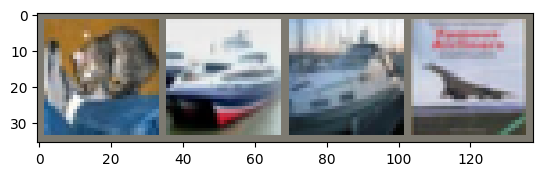

GroundTruth:	 3	8	8	0
Size		Image 1	Image 2	Image 3	Image 4
16		3	8	8	0


In [22]:
nesting_list = [16]
relative_importance = [1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=10, efficient=False)
model = model.to(device)

criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(50):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrlMEAN.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))

| Train   0  | Loss:  1.486  | Acc: 45.110% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     55.57% │     94.39% │
├──────────┼────────────┼────────────┤
│ Average  │     55.57% │     94.39% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   1  | Loss:  1.102  | Acc: 60.532% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     64.10% │     96.73% │
├──────────┼────────────┼────────────┤
│ Average  │     64.10% │     96.73% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   2  | Loss:  0.937  | Acc: 67.012% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  20  | Loss:  0.440  | Acc: 85.140% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     82.02% │     98.55% │
├──────────┼────────────┼────────────┤
│ Average  │     82.02% │     98.55% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  21  | Loss:  0.426  | Acc: 85.700% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     82.96% │     99.06% │
├──────────┼────────────┼────────────┤
│ Average  │     82.96% │     99.06% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  22  | Loss:  0.414  | Acc: 86.026% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  40  | Loss:  0.120  | Acc: 95.932% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     90.83% │     99.66% │
├──────────┼────────────┼────────────┤
│ Average  │     90.83% │     99.66% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  41  | Loss:  0.102  | Acc: 96.522% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     90.93% │     99.73% │
├──────────┼────────────┼────────────┤
│ Average  │     90.93% │     99.73% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  42  | Loss:  0.089  | Acc: 96.978% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


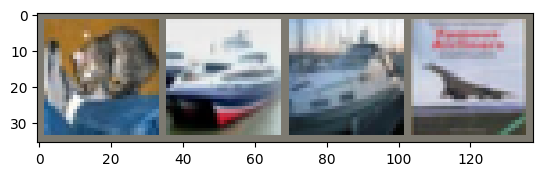

GroundTruth:	 3	8	8	0
Size		Image 1	Image 2	Image 3	Image 4
8		3	8	8	0


In [23]:
nesting_list = [8]
relative_importance = [1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=10, efficient=False)
model = model.to(device)

criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(50):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrlMEAN.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))